<a href="https://colab.research.google.com/github/swishswish123/tracked_surgery_simulations/blob/main/tracked_endoscope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2) TRACKED ENDOSCOPE SIMULATION

In this notebook we want to study the accuracy of a tracked endoscope, and what the expected accuracy of an overlay will be. The overlay accuracy could be measured in terms of accuracy in 3D in the endoscope camera frame, or in terms of 2D pixel accuracy.

Please first read tracked_pointer.ipynb before this notebook for a better understanding of the problem and the maths behind it.

## imports and utility functions


In [162]:
# github repo which contains all the images
!git clone https://github.com/swishswish123/tracked_surgery_simulations.git repo


fatal: destination path 'repo' already exists and is not an empty directory.


In [163]:
# install necessary packages
!pip install scikit-surgerycore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [164]:
# import necessary packages
from scipy.spatial.transform import Rotation as spr
from IPython.display import Image
import cv2
import copy
import sksurgerycore.transforms.matrix as mu
from scipy.spatial.transform import Rotation as spr
import sksurgerycore.algorithms.procrustes as pro
import random
import matplotlib.pyplot as plt
import numpy as np



In [165]:
def extrinsic_matrix_to_vecs(matrix):
    """
    extract_rigid_body_parameters(matrix)
    extracts parameters from transformation matrix

    Args:
        matrix: 4x4 transformation matrix

    Returns:
        list of rigid body parameters [tx, ty, tz, rx, ry, rz]

    """
    t = matrix[0:3, 3]
    r = matrix[0:3, 0:3]
    rot = spr.from_matrix(r)
    euler = rot.as_euler('xyz', degrees=True)
    return [t[0], t[1], t[2], euler[0], euler[1], euler[2]]

def extrinsic_vecs_to_matrix(params):
    """
    rigid_body_parameters_to_matrix(params)
    converts a list of rigid body parameters to transformation matrix

    Args:
        params: list of rigid body parameters [tx, ty, tz, rx, ry, rz]

    Returns:
        4x4 transformation matrix of these parameters

    """
    matrix = np.eye(4)
    
    matrix[0][3] = params[0]
    matrix[1][3] = params[1]
    matrix[2][3] = params[2]

    r = (spr.from_euler('xyz', [params[3], params[4], params[5]], degrees=True)).as_matrix()
    matrix[0:3, 0:3] = r
    return matrix


def multiply_points_by_transform(D3_hom, T):
    """
    Applies a 4x4 transformation matrix to a set of 3D points.

    Args:
        D3_points (numpy.ndarray): Array of 3D points with shape (N, 3).
        T (numpy.ndarray): 4x4 transformation matrix.

    Returns:
        (numpy.ndarray) Array of transformed 3D points with shape (N, 3).
    """
    D3_transformed_points_hom = T @ D3_hom.T
    return D3_transformed_points_hom.T

## Background, System Layout, goal and assumptions

The following diagram shows the layout of the navigation system and the different components involved in the surgery when using a tracked endoscope for AR.



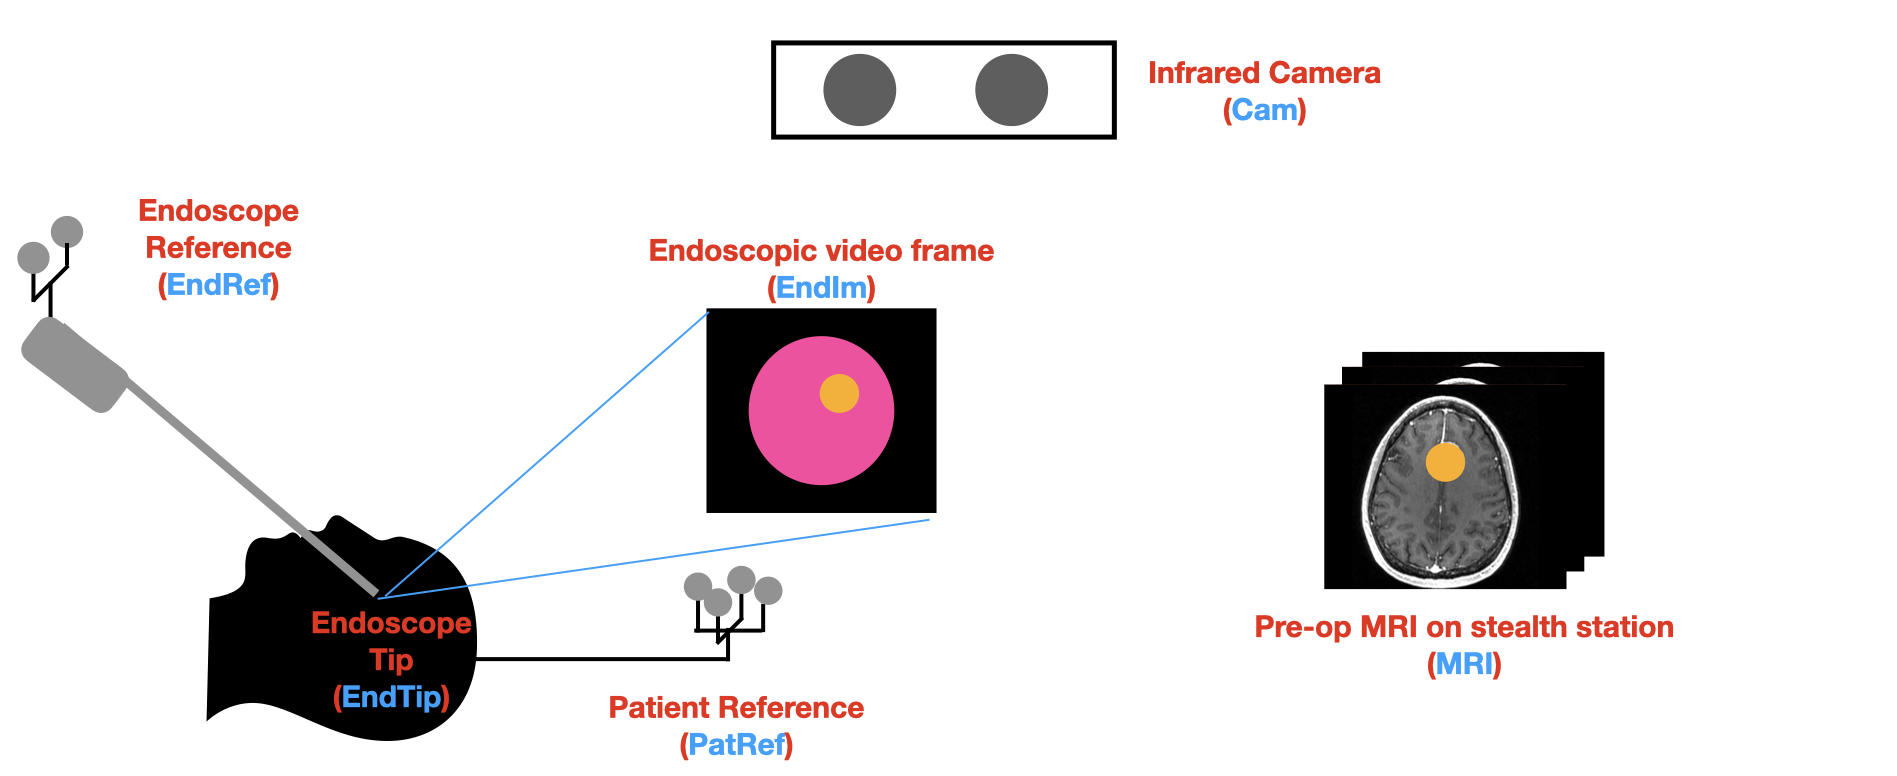

In [166]:
Image(filename="./repo/assets/endoscope_setup.png")


The goal is to be able to display some segmented piece of information from the pre-operative MRI in MRI coordinates onto the endoscopic video:

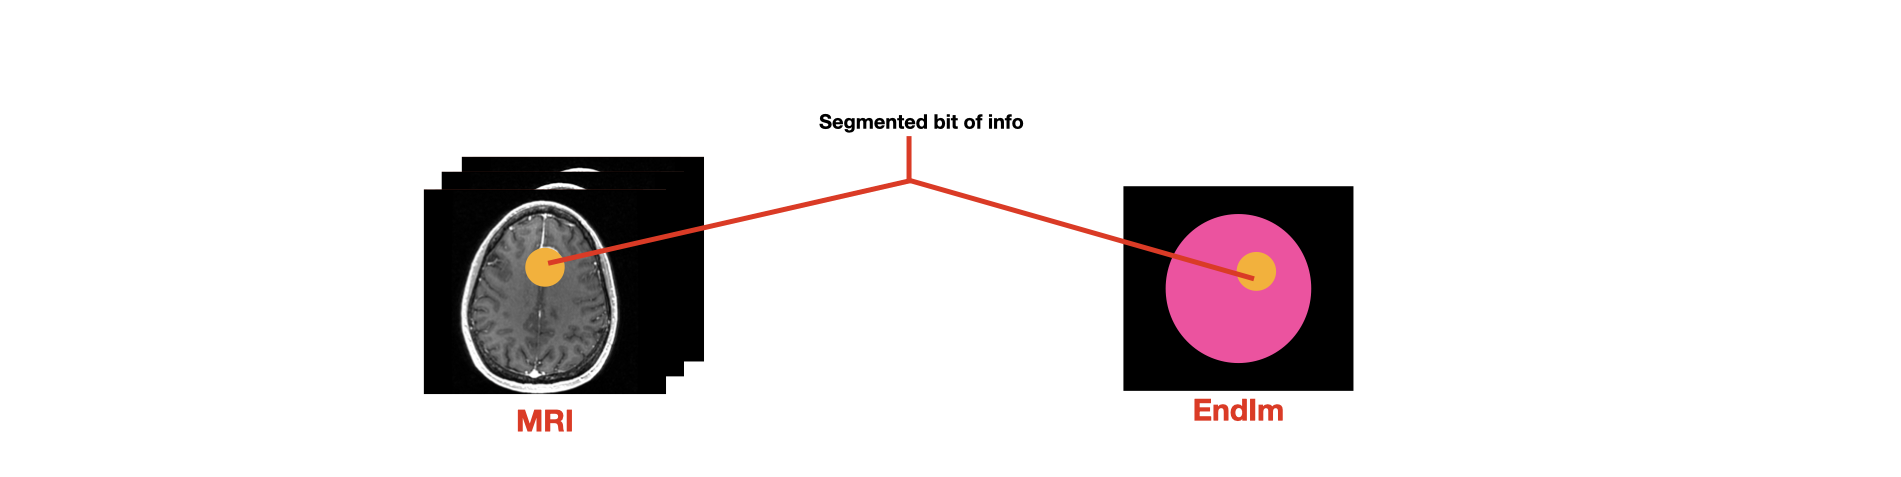

In [167]:
Image(filename="./repo/assets/endoscope_goal.png")


The goal is therefore turning some segmented MRI coordinates to Endoscopic Image (EndIm) coordinates.

X<sub>EndIm</sub> = T X<sub>MRI</sub>

where T is composed of the following transforms:

T = <sup>EndIm</sup>T<sub>EndP</sub> * 
    <sup>EndP</sup>T<sub>EndRef</sub> * 
    <sup>EndRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>MRI</sub>
    


Here is an visual representation of the endoscope setup with all the transforms:


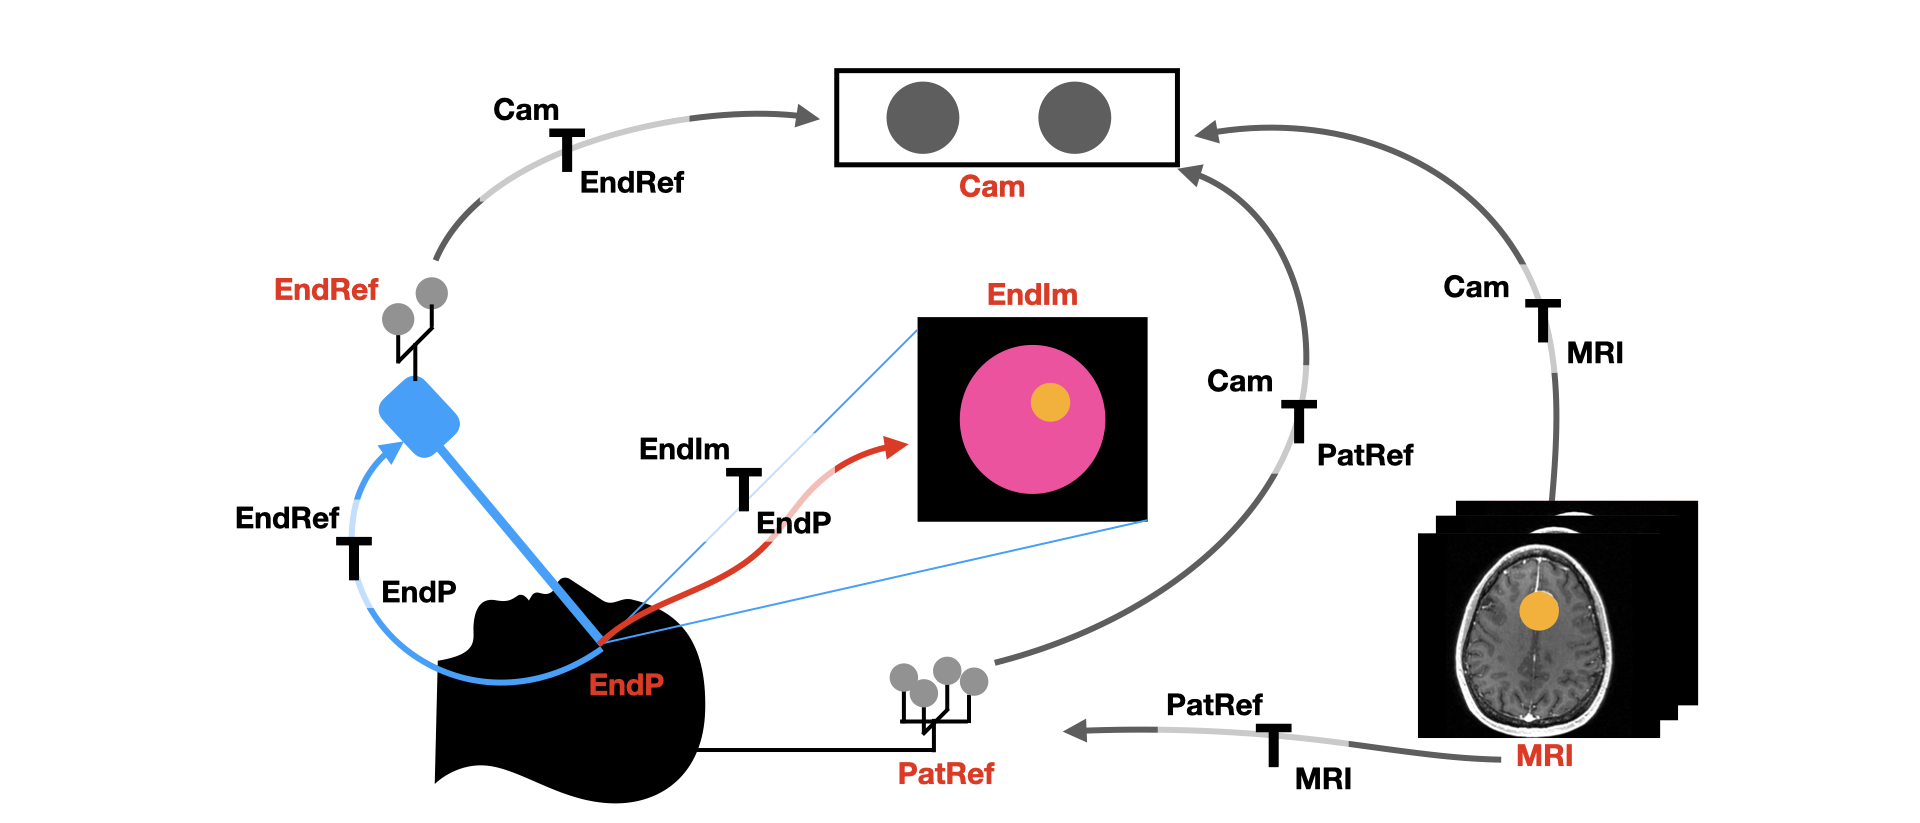

In [168]:
Image(filename="./repo/assets/endoscope_setup_transforms.png")

In the following sections we will go step by step on how to go from each of these transforms

## Assumptions

In order to make this a like-for-like comparison to the tracked pointer simulation, we should keep most of the reference data identical. The difference now, is we swap a pointer for an endoscope. We will need an additional hand-eye calibration, and reference data to project from camera space onto image space, but we leave all other data the same. 

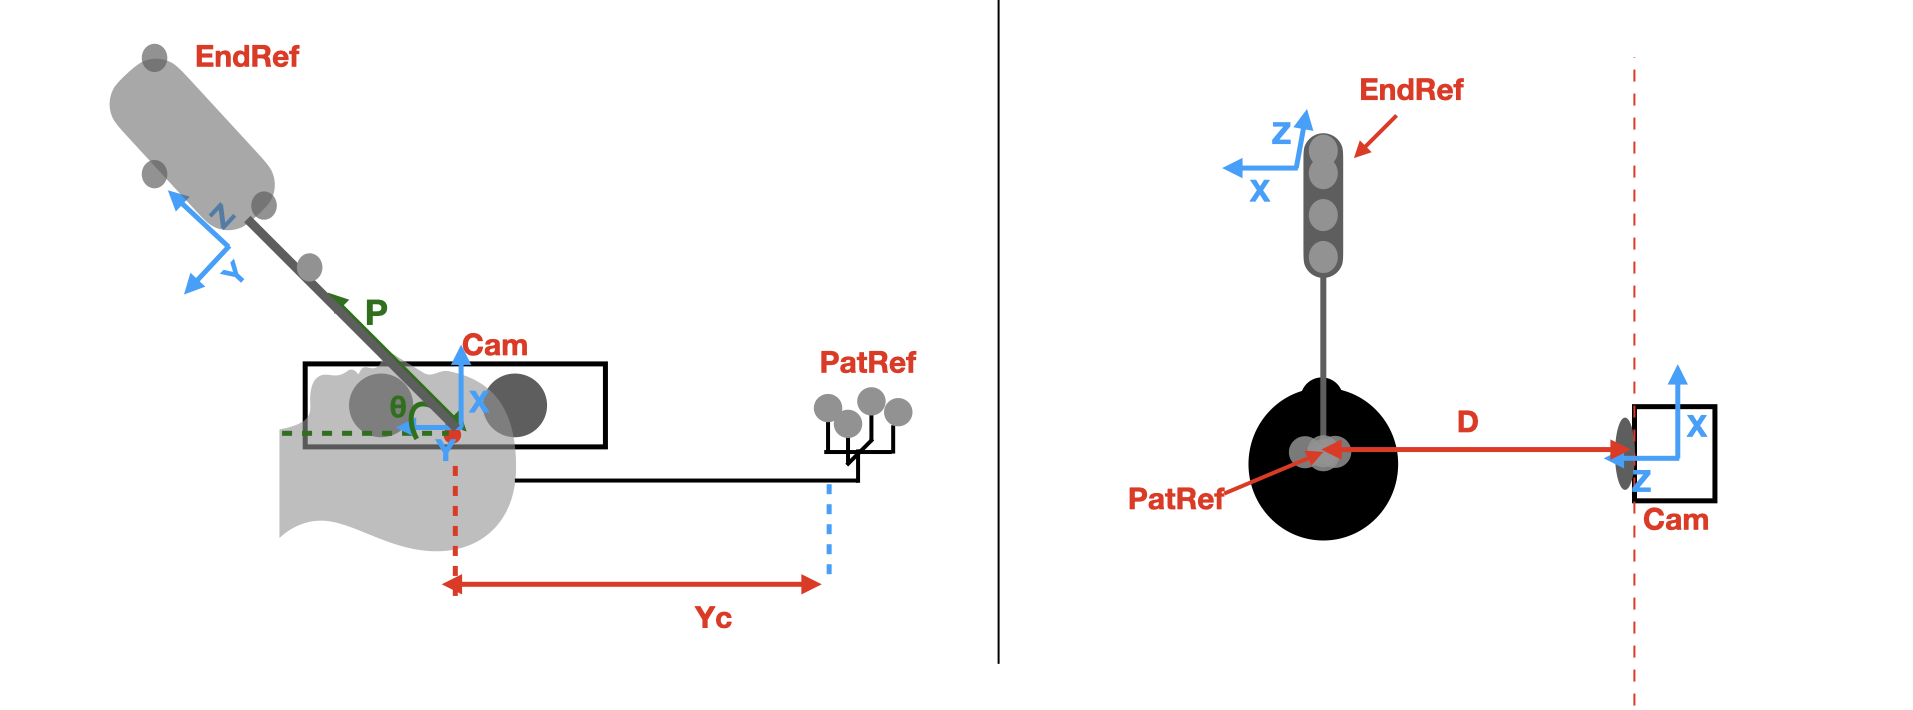

In [169]:
Image(filename="./repo/assets/endoscope_setup_assumptions.png")


In [170]:
# P - , the length of the endoscope.
ENDOSCOPE_LENGTH = 180 # use 300 after merging

# D - z distance from camera to plane where everything is located
DISTANCE_FROM_CAM = 2000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
ENDOSCOPE_ANGLE = 45

# Yc - distances from tumour to patient reference
TUMOUR_PATREF = 300  

# NDI quotes 0.25mm for Polaris Spectra, some papers estimate it at 0.17mm
#TYPICAL_TRACKING_SIGMA = 0.25

# For Model 2 and 3, using an endoscope, this determines the distance of a target of interest from the endoscope.
#working_distance = 50

# for simulation to be reproducible
NUMBER_SAMPLES = 100

X_T = 100 # head length (about 20cm)
Y_T = 130 # menton to top of head (about 25cm)
Z_T = 80 # head bredth (about 15cm)

END_SIGMA=0.5
SIGMA_STEP=0.01

## Defining references

We will use the same reference coordinates as used by the pointer in this simulation to ensure the two are easily comparable.

The patient reference will be set up exactly the same. However, what was previously the pointer reference will now be the endoscope reference (EndRef) and so instead of the pointer length there will be an endoscope length between the endoscope's camera, and the first marker.

In [171]:
def create_pat_ref():
    """
    Create reference coordinates of a marker pattern in a numpy matrix.

    This function creates a numpy matrix containing the reference coordinates of a marker pattern used for
    pose estimation. The marker pattern consists of four markers labeled A, B, C and D. The reference coordinates
    of each marker point are defined in a right-handed reference frame as follows:

        Marker A: (0, 0, 0)
        Marker B: (41.02, 0, 28.59)
        Marker C: (88.00, 0, 0)
        Marker D: (40.45, 0, -44.32)

    The function returns a 4x4 numpy matrix containing the homogenous coordinates of each marker point, with the
    last element of each row set to 1.

    Returns:
        numpy.ndarray: A 4x4 numpy matrix containing reference coordinates of a marker pattern. Each row represents a
        marker point in homogenous coordinates.
    """

    # Encoding the reference marker points into a numpy matrix
    pat_ref = np.zeros((4, 4))
    # marker A (0) -> (0,0,0)

    # marker B (1) -> (41.02 ,0,28.59)
    pat_ref[1][0] = 41.02  # x
    pat_ref[1][2] = 28.59  # z

    # marker C (2) -> C = (88.00 ,0, 0)
    pat_ref[2][0] = 88  # x

    # marker D (3) -> (40.45,0,-44.32)
    pat_ref[3][0] = 40.45  # x
    pat_ref[3][2] = -44.32  # z

    # adding 1 to last row to make coordinates homogenous
    pat_ref[0][3] = 1.0
    pat_ref[1][3] = 1.0
    pat_ref[2][3] = 1.0
    pat_ref[3][3] = 1.0
    return pat_ref


def create_end_ref():
    """
    Creates a numpy matrix representing the endoscope reference coordinates.

    Returns:
    end_ref (numpy matrix): A 4x4 numpy matrix containing the pointer reference coordinates
                            as row vectors in homogenous coordinates. The four rows represent
                            the markers A, B, C, and D in that order.
    """
    # Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
    end_ref = np.zeros((4, 4))

    # marker A (0) -> 0,0,0

    # marker B (1) -> 0,50,0
    end_ref[1][1] = 50  # y

    # marker c (2) -> 25,100,0
    end_ref[2][0] = 25  # x
    end_ref[2][1] = 100  # y

    # marker d (3) -> -25, 135, 0
    end_ref[3][0] = -25  # x
    end_ref[3][1] = 135  # y

    # adding 1 to 3rd dimension to turn to homogeneous coordinates
    end_ref[0][3] = 1
    end_ref[1][3] = 1
    end_ref[2][3] = 1
    end_ref[3][3] = 1

    return end_ref

## Obtaining transforms


Remember we want at the end a composition of all these transforms:

T = <sup>EndIm</sup>T<sub>EndP</sub> * 
    <sup>EndP</sup>T<sub>EndRef</sub> * 
    <sup>EndRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>MRI</sub>
  
Most of these are obtained in a similar way to the pointer simulation although flipped as we are going from the MRI coordinates. Since we are assuming the layout and relative positions of each reference marker, we are able to obtain the transformations between each coordinate system.

The function below generates these transformations with the given pointer length and the parameters defined in the assumptions section.

In [172]:
def get_transforms(endoscope_length=200, ENDOSCOPE_ANGLE=45,DISTANCE_FROM_CAM=2000, TUMOUR_PATREF=40  ):
    """
    Returns a set of coordinate transformation matrices that convert points from one reference frame to another.

    Args:
        endoscope_length (float): Length of the endoscope in millimeters. Default is 200.
        ENDOSCOPE_ANGLE (float): z angle at which endoscope is angled
        DISTANCE_FROM_CAM (float): distance from camera to patient
        TUMOUR_PATREF (float): distance from tumour to patient reference

    Returns:
        tuple: A tuple containing the following eight transformation matrices:
        - PatRef_T_MRI: A 4x4 transformation matrix that converts points from the MRI reference frame to the patient reference frame.
        - Cam_T_PatRef: A 4x4 transformation matrix that converts points from the patient reference frame to the camera reference frame.
        - EndRef_T_Cam: A 4x4 transformation matrix that converts points from the camera reference frame to the endoscope reference frame. 
        - EndP_T_EndRef: A 4x4 transformation matrix that converts points from the endoscope reference frame to the endoscope tip reference frame.

        and the following numpy arrays containing the homogenous coordinates of the points in the given reference frame
        - end_ref_marker:  endRef in the pointer reference frame.
        - end_ref_cam: endRef in the camera reference frame.
        
        - pat_ref_marker: patRef in the patient reference frame.
        - pat_ref_cam: patRef in the camera reference frame.

    """

    # 1) obtaining EndRef_T_EndP
    #print(f'endoscope length: {endoscope_length}')
    # Creating pointer reference in the pointer reference frame.
    end_ref_marker = create_end_ref() # marker coords
    # Point reference to point tip: (pointer length translation in y)
    EndP_T_EndRef = extrinsic_vecs_to_matrix(
        [0, endoscope_length, 0, 0, 0, 0]) # create transform of all points depending on pointer's length
    # invert to get tip to ref:
    #EndRef_T_EndP = np.linalg.inv(EndP_T_EndRef)

    # 2) obtaining Cam_T_EndRef
    # Converting the marker points to the camera reference frame by applying a
    # rotation of ENDOSCOPE_ANGLE degrees about the z-axis followed by a
    # translation of DISTANCE_FROM_CAM along the z-axis of camera.
    rotate_about_z = extrinsic_vecs_to_matrix([0, 0, 0, 0, 0, ENDOSCOPE_ANGLE])
    translate_away_from_camera = extrinsic_vecs_to_matrix([0, 0, DISTANCE_FROM_CAM, 0, 0, 0])
    Cam_T_EndRef = translate_away_from_camera @ rotate_about_z
    end_ref_cam = multiply_points_by_transform(end_ref_marker, Cam_T_EndRef)
    EndRef_T_Cam = np.linalg.inv(Cam_T_EndRef)

    # 3) obtaining Cam_T_PatRef
    # PatRef to Cam (add dist to cam to z plus x translation to right)
    pat_ref_marker = create_pat_ref()
    # translating to correct location 
    translate_along_x = extrinsic_vecs_to_matrix([TUMOUR_PATREF, 0, 0, 0, 0, 0])
    Cam_T_PatRef = translate_along_x @ translate_away_from_camera
    pat_ref_cam = multiply_points_by_transform(pat_ref_marker, Cam_T_PatRef)
    #PatRef_T_Cam = np.linalg.inv(Cam_T_PatRef)

    # 4) obtaining PatRef_T_MRI
    PatRef_T_MRI = extrinsic_vecs_to_matrix([X_T, Y_T, Z_T, 0, 0, 0])
    #MRI_T_PatRef = np.linalg.inv(PatRef_T_MRI)

    return EndP_T_EndRef,EndRef_T_Cam,Cam_T_PatRef,PatRef_T_MRI  , end_ref_marker, end_ref_cam, pat_ref_marker, pat_ref_cam


In [173]:
EndP_T_EndRef,EndRef_T_Cam,Cam_T_PatRef,PatRef_T_MRI  , end_ref_marker, end_ref_cam, pat_ref_marker, pat_ref_cam= get_transforms(endoscope_length=ENDOSCOPE_LENGTH, ENDOSCOPE_ANGLE=ENDOSCOPE_ANGLE,DISTANCE_FROM_CAM=DISTANCE_FROM_CAM, TUMOUR_PATREF=TUMOUR_PATREF)


In [174]:

print('our 4 transforms:')

print('PatRef_T_MRI')
print(PatRef_T_MRI)

print('Cam_T_PatRef')
print(Cam_T_PatRef)

print('EndRef_T_Cam')
print(EndRef_T_Cam)

print('EndP_T_EndRef')
print(EndP_T_EndRef)


print('reference frames represented in different coordinate systems')
print('end_ref_marker')
print(end_ref_marker)

print('end_ref_cam')
print(end_ref_cam)

print('pat_ref_marker')
print(pat_ref_marker)

print('pat_ref_cam')
print(pat_ref_cam)

our 4 transforms:
PatRef_T_MRI
[[  1.   0.   0. 100.]
 [  0.   1.   0. 130.]
 [  0.   0.   1.  80.]
 [  0.   0.   0.   1.]]
Cam_T_PatRef
[[1.e+00 0.e+00 0.e+00 3.e+02]
 [0.e+00 1.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+00 2.e+03]
 [0.e+00 0.e+00 0.e+00 1.e+00]]
EndRef_T_Cam
[[ 7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [-7.07106781e-01  7.07106781e-01 -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -2.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
EndP_T_EndRef
[[  1.   0.   0.   0.]
 [  0.   1.   0. 180.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
reference frames represented in different coordinate systems
end_ref_marker
[[  0.   0.   0.   1.]
 [  0.  50.   0.   1.]
 [ 25. 100.   0.   1.]
 [-25. 135.   0.   1.]]
end_ref_cam
[[ 0.00000000e+00  0.00000000e+00  2.00000000e+03  1.00000000e+00]
 [-3.53553391e+01  3.53553391e+01  2.00000000e+03  1.00000000e+00]
 [-5.30330086e+01  8.83883476e+01 

## Simulations

In the following section we will perform our experiments when adding noise to different parts of the setup.



First let's define some necessary utility functions



In [175]:
def project_points(points, T, intrinsics, distortion): # target_location_in_marker_space, target_location_in_mri_space,
    params = extrinsic_matrix_to_vecs(T)
    # project noisy target point from camera space to image space
    rvec = np.zeros((1,3))
    tvec = np.zeros((1,3))
    
    tvec[0,0]=params[0]
    tvec[0,1]=params[1]
    tvec[0,2]=params[2]

    rvec[0,0]=params[3]
    rvec[0,1]=params[4]
    rvec[0,2]=params[5]

    #rvec = np.array([Cam_T_EndRef_parameters[:3]], dtype=float)
    #tvec = np.array([Cam_T_EndRef_parameters[4:]], dtype=float)
    transformed_point, _ = cv2.projectPoints(points[:3], rvec, tvec, intrinsics, distortion)
    transformed_point = transformed_point.squeeze()
    return transformed_point

def add_noise_to_points(points_in, sigma):
    """
    add_noise_to_points(points_in, sigma)
    adding noise to 3D points

    Args:
        points_in: 3xN matrix of points we are adding noise to
        sigma: standard deviation of normal distribution defining noise distribution

    Returns:
        same points but with random noise added to them
    """
    
    points_out = np.zeros((points_in.shape))
    for r in range(points_in.shape[0]):
        for c in range(points_in.shape[1]):
            points_out[r][c] = points_in[r][c] + random.normalvariate(0, sigma)
    return points_out


def add_noise_to_params(params, sigma):
    """
    add_noise_to_params(params, sigma)
    adds noise to parameters (translation, rotation etc)

    Args:
        params: list of all parameters (translations in xyz, rotations in etc.)
        sigma: standard deviation of normal noise to add

    Returns:
        parameters with noise added on them
    """
    params_out = copy.deepcopy(params)
    for i, p in enumerate(params):
        params_out[i] = params[i] + random.normalvariate(0, sigma)
    return params_out


def calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space ):
    """
    calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space )
    calculates euclidean distance between two 3D points (euclid_dist is x^2+y^2+x^2)

    Args:
        pointer_tip_in_mri_space: 4x1 np array of where we think the tumor is
        tumour_in_mri_space: 4x1 np array of where the tumor actually is

    Returns:
        euclidean distance between the two points
    """

    dist =  (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
            * (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
            + (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
            * (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
            + (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2]) \
            * (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2])

    return dist

the following is the main function for performing the simulation with different sources of errors

In [176]:
def simulation(EndP_T_EndRef=0, EndRef_T_Cam=0, Cam_T_PatRef=0, PatRef_T_MRI=0, end_ref_marker=0, end_ref_cam=0,
               pat_ref_marker=0, pat_ref_cam=0,NUMBER_SAMPLES=1000,END_SIGMA=0.5 ,SIGMA_STEP=0.01,  
               add_reg_error=False, add_tracking_noise=False, add_hand_eye_error=False, AR=False):
    """
    This function simulates the tracking of a pointer using a camera-based system, and evaluates the accuracy of the
    tracked pointer in MRI space. The function can simulate different scenarios by adding noise to the reference points
    in camera space or adding error to the registration between patient space and MRI space. The function returns the
    root mean squared (RMS) error between the target location of the pointer in MRI space and the tracked location.

    Args:
        The following are rigid transformations from the coordinate system on the right of T
            to the coordinate system on the left of T
        EndP_T_EndRef (numpy.ndarray): RT from endoscope reference to endoscope tip
        EndRef_T_Cam (numpy.ndarray): RT from camera to endoscope reference
        Cam_T_PatRef (numpy.ndarray): RT from patient reference to camera
        PatRef_T_MRI (numpy.ndarray): RT from MRI to patient reference

        end_ref_marker (numpy.ndarray): The position of the endoscope reference frame in marker space.
        end_ref_cam (numpy.ndarray): The position of the endoscope reference frame in camera space.
        pat_ref_marker (numpy.ndarray): The position of the patient reference frame in marker space.
        pat_ref_cam (numpy.ndarray): The position of the patient reference frame in camera space.

        NUMBER_SAMPLES (int): number of samples for error reproducibility
        END_SIGMA (int): max gaussian noise standard deviation to be calculated
        SIGMA_STEP (int): steps in which to increase gaussian noise std 

        add_reg_error (bool): If True, add noise to the parameters of the registration between the patient reference
            frame and the MRI reference frame.
        add_tracking_noise (bool): If True, add noise to the position of the reference frames in camera space.
        add_hand_eye_error (bool): If True, add noise to hand-eye params
        AR (bool): If True this is the AR experiment so error would be in pxls

    Returns:
        numpy.ndarray: The x-values of the RMS error plot.
        numpy.ndarray: The y-values of the RMS error plot.

    """

    x_values = []
    y_values = []

    # create a target location at the tip of the pointer in marker space
    target_location_in_marker_space = np.zeros((4, 1))
    target_location_in_marker_space[3, 0] = 1  # homogeous

    # compute the transform from MRI to point at tip of pointer
    #MRI_T_PntTip = MRI_T_PatRef @ PatRef_T_Cam @ Cam_T_PntRef @ PntRef_T_PntTip
    #MRI_T_EndP = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) @ Cam_T_EndRef @  EndRef_T_EndP
    EndP_T_MRI = EndP_T_EndRef @ EndRef_T_Cam @ Cam_T_PatRef @  PatRef_T_MRI

    # transform target location to MRI space
    #target_location_in_mri_space = MRI_T_PntTip @ target_location_in_marker_space
    target_location_in_mri_space = np.linalg.inv(EndP_T_MRI) @ target_location_in_marker_space

    if AR:
        T = np.linalg.inv(EndP_T_EndRef @ EndRef_T_Cam)
        target_location_in_image_coordinates = project_points(target_location_in_mri_space[:3], T, intrinsics, distortion)
            
    ###### CHANGE ALL PatRef_T_Cam AND MRI_T_PatRef
    #MRI_T_PatRef_original = copy.deepcopy(MRI_T_PatRef)
    PatRef_T_MRI_original = copy.deepcopy(PatRef_T_MRI)
    EndP_T_EndRef_original = copy.deepcopy(EndP_T_EndRef)

    #### -------- CHECK BELOW
    for sigma in np.arange(0, END_SIGMA + SIGMA_STEP, SIGMA_STEP):
        # sigma = float(sigma_counter) / float(100)
        # print(sigma)
        rms = 0
        for i in range(NUMBER_SAMPLES):

            if add_tracking_noise:
                # add tracking noise to the reference points in camera space
                noisy_end_ref_cam = add_noise_to_points(end_ref_cam[:, 0:3], sigma)
                # compute transforms with the noisy reference points (from references to camera)
                R, t, FRE = pro.orthogonal_procrustes(noisy_end_ref_cam[:, 0:3], end_ref_marker[:, 0:3])
                Cam_T_EndRef = mu.construct_rigid_transformation(R, t)
                EndRef_T_Cam = np.linalg.inv(Cam_T_EndRef)

                # same for patient reference
                noisy_pat_ref_cam = add_noise_to_points(pat_ref_cam[:, 0:3], sigma)
                R, t, FRE = pro.orthogonal_procrustes(pat_ref_marker[:, 0:3], noisy_pat_ref_cam[:, 0:3])
                PatRef_T_Cam = mu.construct_rigid_transformation(R, t)
                Cam_T_PatRef = np.linalg.inv(PatRef_T_Cam)

            if add_reg_error:
                # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
                PatRef_T_MRI_parameters = extrinsic_matrix_to_vecs(PatRef_T_MRI_original)
                PatRef_T_MRI_noisy_parameters = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
                PatRef_T_MRI = extrinsic_vecs_to_matrix(PatRef_T_MRI_noisy_parameters)

            if add_hand_eye_error:
                # adding hand eye noise to parameters then reconstruct noisy transformation
                Hand_T_Eye_parameters = extrinsic_matrix_to_vecs(EndP_T_EndRef_original)
                noisy_hand_eye_params = add_noise_to_params(Hand_T_Eye_parameters, sigma)
                EndP_T_EndRef = extrinsic_vecs_to_matrix(noisy_hand_eye_params)


            # use noisy transforms to get a target location from camera space to MRI space.            
            EndP_T_MRI_noisy = EndP_T_EndRef @ EndRef_T_Cam @ Cam_T_PatRef @  PatRef_T_MRI
            target_location_in_mri_space_noisy = np.linalg.inv(EndP_T_MRI_noisy) @ target_location_in_marker_space

            # calculate euclidean distance between noisy transformed point and target location (in MRI space or image space depending on simulation)
            if AR:
                
                T_noisy = np.linalg.inv(EndP_T_EndRef @ EndRef_T_Cam)
                transformed_point_in_image_space_noisy = project_points(target_location_in_mri_space_noisy[:3], T_noisy, intrinsics, distortion)

                euclid_dist =  (transformed_point_in_image_space_noisy[0] - target_location_in_image_coordinates[0]) \
                        * (transformed_point_in_image_space_noisy[0] - target_location_in_image_coordinates[0]) \
                        + (transformed_point_in_image_space_noisy[1] - target_location_in_image_coordinates[1]) \
                        * (transformed_point_in_image_space_noisy[1] - target_location_in_image_coordinates[1]) 

            else:
                euclid_dist = calculate_euclid_dist(target_location_in_mri_space_noisy, target_location_in_mri_space)
            
            rms = rms + float(euclid_dist)

        # calculating root mean square
        rms = rms / float(NUMBER_SAMPLES)
        rms = np.sqrt(rms)

        x_values.append(sigma)
        y_values.append(rms)

    return np.array(x_values), np.array(y_values)

The following is simply for visualising the results



In [177]:
def plot_TRE_results(x,y,title=''):
    plt.figure()
    plt.title(title)
    plt.plot(x, y, 'r', label='TRE (mm)')
    plt.legend(loc='upper left')
    plt.xlabel('sigma ')
    plt.ylabel('TRE (mm)')
    plt.show()

and the intrinsics and distortion parameters that will be used to project the points from 3D to 2D. These parameters were obtained by calibrating the endoscope with Zhang's camera calibration algorithm 

In [178]:
intrinsics = np.array([
    [664.63297660, 0.00000000, 931.53151205],
    [0.00000000, 663.83211807, 520.64004697],
    [0.00000000, 0.00000000, 1.00000000]
])

distortion = np.array([
    -0.40929449, 0.21631278, 0.00001112, 0.00127120, -0.07205712
])

### Tracking error

In [179]:
tracking_x_values, tracking_y_values = simulation(EndP_T_EndRef=EndP_T_EndRef, 
                  EndRef_T_Cam=EndRef_T_Cam, 
                  Cam_T_PatRef=Cam_T_PatRef, 
                  PatRef_T_MRI=PatRef_T_MRI, 

                  end_ref_marker=end_ref_marker, 
                  end_ref_cam=end_ref_cam,
                  pat_ref_marker=pat_ref_marker, 
                  pat_ref_cam=pat_ref_cam,
                  
                  NUMBER_SAMPLES=NUMBER_SAMPLES,
                  END_SIGMA=END_SIGMA ,
                  SIGMA_STEP=SIGMA_STEP,  

                  add_reg_error=False, 
                  add_tracking_noise=True, 
                  add_hand_eye_error=False, 
                  AR=False)

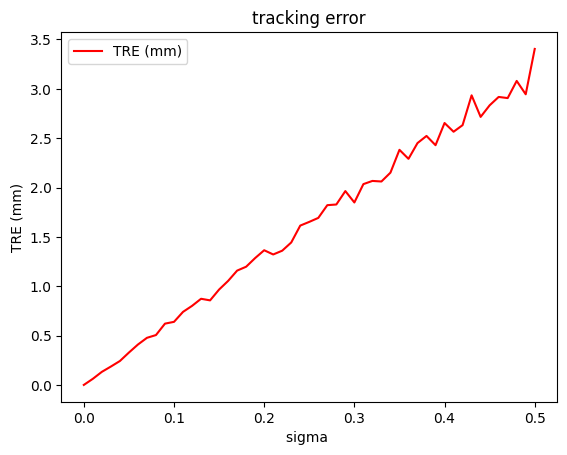

In [180]:
plot_TRE_results(tracking_x_values,tracking_y_values,title='tracking error')


### Registration error

In [181]:
registration_x_values, registration_y_values = simulation(EndP_T_EndRef=EndP_T_EndRef, 
                  EndRef_T_Cam=EndRef_T_Cam, 
                  Cam_T_PatRef=Cam_T_PatRef, 
                  PatRef_T_MRI=PatRef_T_MRI, 

                  end_ref_marker=end_ref_marker, 
                  end_ref_cam=end_ref_cam,
                  pat_ref_marker=pat_ref_marker, 
                  pat_ref_cam=pat_ref_cam,
                  
                  NUMBER_SAMPLES=NUMBER_SAMPLES,
                  END_SIGMA=END_SIGMA,
                  SIGMA_STEP=SIGMA_STEP,  

                  add_reg_error=True, 
                  add_tracking_noise=False, 
                  add_hand_eye_error=False, 
                  AR=False)

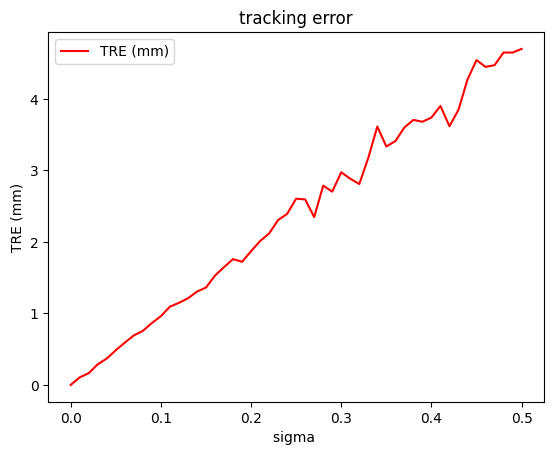

In [182]:
plot_TRE_results(registration_x_values, registration_y_values,title='tracking error')


## hand_eye

In [183]:
hand_eye_x_values, hand_eye_y_values = simulation(EndP_T_EndRef=EndP_T_EndRef, 
                  EndRef_T_Cam=EndRef_T_Cam, 
                  Cam_T_PatRef=Cam_T_PatRef, 
                  PatRef_T_MRI=PatRef_T_MRI, 

                  end_ref_marker=end_ref_marker, 
                  end_ref_cam=end_ref_cam,
                  pat_ref_marker=pat_ref_marker, 
                  pat_ref_cam=pat_ref_cam,
                  
                  NUMBER_SAMPLES=NUMBER_SAMPLES,
                  END_SIGMA=END_SIGMA,
                  SIGMA_STEP=SIGMA_STEP,  

                  add_reg_error=False, 
                  add_tracking_noise=False, 
                  add_hand_eye_error=True, 
                  AR=False)

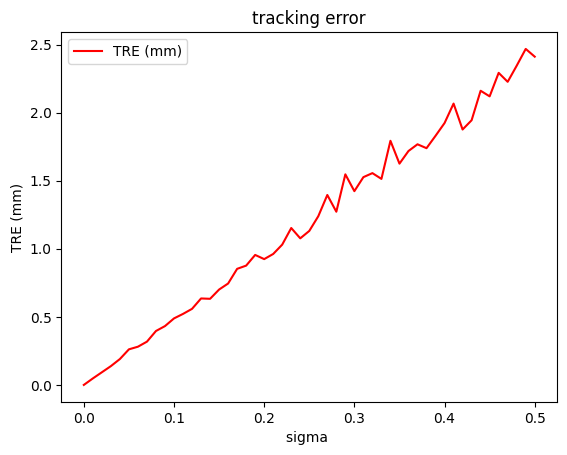

In [184]:
plot_TRE_results(hand_eye_x_values, hand_eye_y_values,title='tracking error')


### AR 

In [185]:
AR_x_values, AR_y_values = simulation(EndP_T_EndRef=EndP_T_EndRef, 
                  EndRef_T_Cam=EndRef_T_Cam, 
                  Cam_T_PatRef=Cam_T_PatRef, 
                  PatRef_T_MRI=PatRef_T_MRI, 

                  end_ref_marker=end_ref_marker, 
                  end_ref_cam=end_ref_cam,
                  pat_ref_marker=pat_ref_marker, 
                  pat_ref_cam=pat_ref_cam,
                  
                  NUMBER_SAMPLES=NUMBER_SAMPLES,
                  END_SIGMA=END_SIGMA ,
                  SIGMA_STEP=SIGMA_STEP,  

                  add_reg_error=True, 
                  add_tracking_noise=True, 
                  add_hand_eye_error=True, 
                  AR=True)

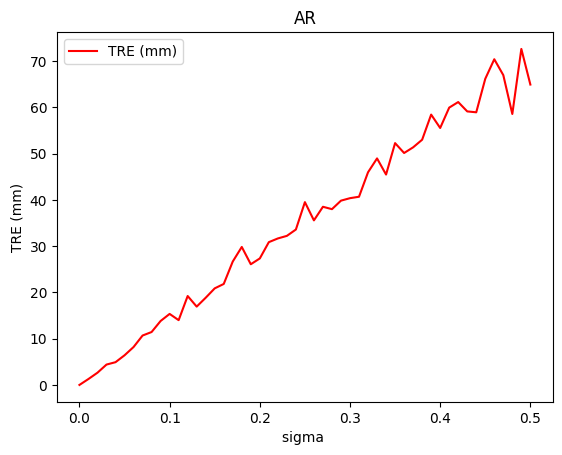

In [186]:
plot_TRE_results(AR_x_values,AR_y_values,title='AR')


### Total error in mm

In [187]:
total_x_values, total_y_values = simulation(EndP_T_EndRef=EndP_T_EndRef, 
                  EndRef_T_Cam=EndRef_T_Cam, 
                  Cam_T_PatRef=Cam_T_PatRef, 
                  PatRef_T_MRI=PatRef_T_MRI, 

                  end_ref_marker=end_ref_marker, 
                  end_ref_cam=end_ref_cam,
                  pat_ref_marker=pat_ref_marker, 
                  pat_ref_cam=pat_ref_cam,
                  
                  NUMBER_SAMPLES=NUMBER_SAMPLES,
                  END_SIGMA=END_SIGMA ,
                  SIGMA_STEP=SIGMA_STEP,  

                  add_reg_error=True, 
                  add_tracking_noise=True, 
                  add_hand_eye_error=True, 
                  AR=False)

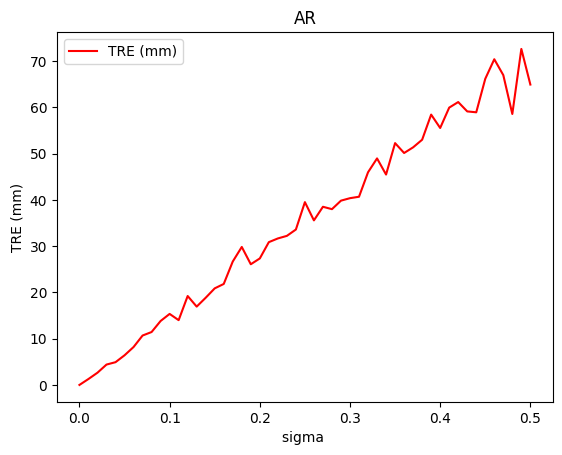

In [188]:
plot_TRE_results(AR_x_values,AR_y_values,title='AR')


## Summary

In [189]:
print('tracking error')
print(tracking_y_values[tracking_x_values == 0.2])

tracking error
[1.3644879]


In [190]:
print('registration error')
print(registration_y_values[registration_x_values == 0.2])

registration error
[1.86948722]


In [191]:
print('hand eye error')
print(hand_eye_y_values[hand_eye_x_values == 0.2])

hand eye error
[0.92408496]


In [192]:
print('total error')
print(total_y_values[total_x_values == 0.2])

total error
[2.6307207]
